In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

import zipfile
import pandas as pd
import os
from tqdm import tqdm

# Save the model
modelPath = 'models/model2/'
# change name modle here
model_name = 'model2.pth'

In [82]:
import os
import pandas as pd

path = 'ChengDuData'
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

combined_dataframe = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(path, file)
    temp_df = pd.read_csv(file_path)
    
    # Compute the average travel time
    temp_df['Average_Travel_Time'] = temp_df.iloc[:, 8:59].mean(axis=1)
    
    # Extract time period information from file name
    time_period = file.replace('.csv', '').replace('_', ' ')
    temp_df['Time_Period'] = time_period

    # Select relevant columns (optional, depending on your model requirements)
    temp_df = temp_df[['Link', 'Node_Start', 'Longitude_Start', 'Latitude_Start', 
                       'Node_End', 'Longitude_End', 'Latitude_End', 'Length', 
                       'Average_Travel_Time', 'Time_Period']]
    
    combined_dataframe = pd.concat([combined_dataframe, temp_df], ignore_index=True)

# Now combined_dataframe contains the processed data

In [83]:
print(combined_dataframe.head())

   Link  Node_Start  Longitude_Start  Latitude_Start  Node_End  Longitude_End  \
0     0           0       103.946006       30.750660        16     103.952551   
1     1           0       103.946006       30.750660        48     103.956494   
2     2           0       103.946006       30.750660        64     103.941276   
3     3           1       104.062539       30.739077       311     104.060024   
4     4           1       104.062539       30.739077      1288     104.062071   

   Latitude_End       Length  Average_Travel_Time       Time_Period  
0     30.756752   921.041014            85.424151  Weekday Off peak  
1     30.745080  1179.207157           125.386769  Weekday Off peak  
2     30.754493   620.905375            53.618874  Weekday Off peak  
3     30.742693   467.552294            40.787167  Weekday Off peak  
4     30.732501   730.287581            77.209144  Weekday Off peak  


In [84]:
class TravelTimePredictor(nn.Module):
    def __init__(self):
        super(TravelTimePredictor, self).__init__()
        self.fc1 = nn.Linear(in_features=8, out_features=64)  # Adjusted to match input size
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Linear output for regression
        return x



In [85]:
# Instantiate the model
model = TravelTimePredictor()

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [86]:
# Assuming 'combined_dataframe' is your DataFrame with the prepared data
# Extracting features and target
features = combined_dataframe.drop(['Average_Travel_Time', 'Time_Period'], axis=1).values
target = combined_dataframe['Average_Travel_Time'].values

# Normalizing the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Creating Data Loaders
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)



In [87]:
# change num_epochs here
num_epochs = 100
losses = []

# Training Loop with tqdm on the outer loop
for epoch in tqdm(range(num_epochs), desc='Training Progress', leave=True):
    model.train()
    train_loss = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))  # Ensure the targets tensor is correctly shaped
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    average_loss = train_loss / len(train_loader)
    losses.append(average_loss)
    # print every 10 epochs
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')
    
    if (epoch+1) % 100 == 0:
        torch.save(model.state_dict(), f'./{modelPath}/{model_name}_epoch{epoch+1}.pth')

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


In [88]:
torch.save(model.state_dict(), modelPath + model_name)

In [89]:
# Evaluation
model.eval()
test_loss = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        test_loss += loss.item()

    average_loss = test_loss / len(test_loader)
    print(f'Test Loss: {average_loss:.4f}')


Test Loss: 579.0524


In [90]:
# try the model with one data comparing the result with the real value
model.eval()
with torch.no_grad():
    test_input = X_test_tensor[29].unsqueeze(0)
    test_output = model(test_input)
    print(f'Predicted: {test_output.item()}, Actual: {y_test_tensor[0].item()}')


Predicted: 37.877967834472656, Actual: 64.99746704101562


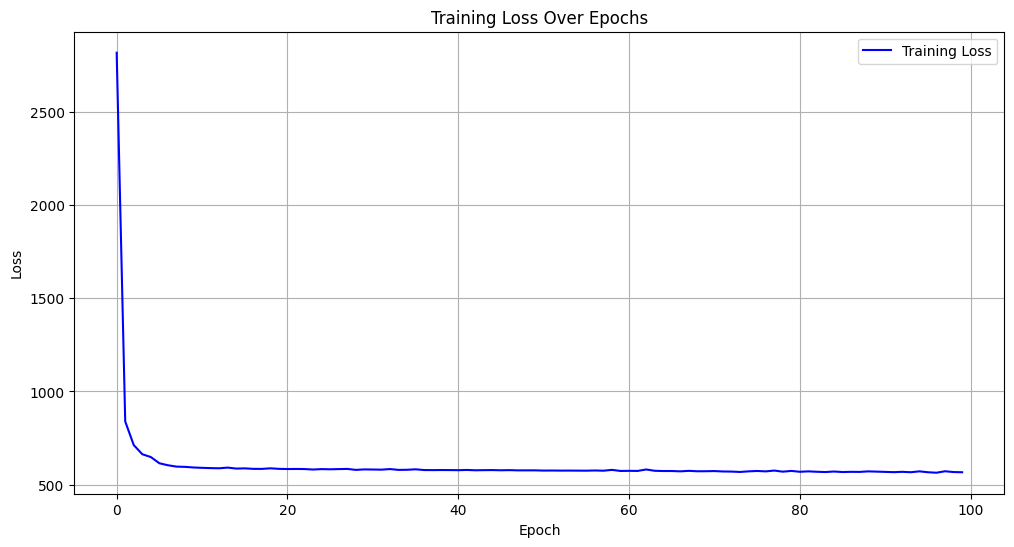

In [92]:
import matplotlib.pyplot as plt

# Assuming 'losses' is a list or array containing the loss values for each epoch
plt.figure(figsize=(12, 6))
plt.plot(losses, label='Training Loss', color='blue', linestyle='-', marker='')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(f"{modelPath}/losses_{model_name[:-4]}.png")

